In [138]:
# Add the source directory to the path
import sys
sys.path.append('/home/sleyse4/repos/LoRE_SD/src')


In [139]:
import os
import subprocess
import shutil

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import varia
from utils import SphericalHarmonics as sh

from simulations import simulation
from optimisation import optimise, contrasts
from mrtrix_io.io import load_mrtrix, save_mrtrix
from mrtrix_io.io.image import Image

In [141]:
# Add the MRtrix3 binary directory to the PATH
mrtrix_bin_dir = '/SOFTWARE/mrtrix3/bin'  # Replace with the actual path to MRtrix3 binaries
os.environ['PATH'] += os.pathsep + mrtrix_bin_dir

In [140]:
sub = 'PT001'

data = load_mrtrix(f'/LOCALDATA/sleyse4/glioma/sub-{sub}/LORE/response.mif')
mask = load_mrtrix(f'/LOCALDATA/sleyse4/glioma/sub-{sub}/mask.mif').data > .5

reg = np.sum(data.data[..., 1:, 1:]/data.data[...,:1,:1] ** 2, axis=(-1,-2))

SLICE_IDX = 72


grad = load_mrtrix(f'/LOCALDATA/sleyse4/glioma/sub-{sub}/dwi.mif').grad
bvals = np.unique(np.round(grad[:,-1], -2))
rf = data.data
fracs = load_mrtrix(f'/LOCALDATA/sleyse4/glioma/sub-{sub}/LORE/gaussian_fractions.mif').data
mask = mask

/tmp/ipykernel_779942/1507652802.py:6: RuntimeWarning: invalid value encountered in divide
  reg = np.sum(data.data[..., 1:, 1:]/data.data[...,:1,:1] ** 2, axis=(-1,-2))


In [142]:
def fa_map(ad, rd):

    ad_matrix = np.repeat(ad[..., None], len(rd), axis=-1)
    rd_matrix = np.repeat(rd[None, ...], len(ad), axis=0)

    mask = ad_matrix >= rd_matrix
    ad_matrix *= mask
    rd_matrix *= mask

    lambda_mean = (ad_matrix + 2*rd_matrix) / 3
    return np.nan_to_num(np.sqrt(3/2) * np.sqrt((ad_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2) / np.sqrt(ad_matrix**2 + rd_matrix**2 + rd_matrix**2))

def ad_over_rd_map(ad, rd):
    ad_matrix = np.repeat(ad[..., None], len(rd), axis=-1)
    rd_matrix = np.repeat(rd[None, ...], len(ad), axis=0)

    mask = (ad_matrix >= rd_matrix)
    
    return np.nan_to_num((ad_matrix-rd_matrix) / (ad_matrix+rd_matrix)) * mask

In [143]:
ad_range, rd_range = np.linspace(0, 4e-3, 10), np.linspace(0, 4e-3, 10)

/tmp/ipykernel_779942/2648233319.py:11: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(np.sqrt(3/2) * np.sqrt((ad_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2) / np.sqrt(ad_matrix**2 + rd_matrix**2 + rd_matrix**2))
/tmp/ipykernel_779942/2648233319.py:11: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(np.sqrt(3/2) * np.sqrt((ad_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2) / np.sqrt(ad_matrix**2 + rd_matrix**2 + rd_matrix**2))
/tmp/ipykernel_779942/2648233319.py:11: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(np.sqrt(3/2) * np.sqrt((ad_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2) / np.sqrt(ad_matrix**2 + rd_matrix**2 + rd_matrix**2))
/tmp/ipykernel_779942/2648233319.py:11: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(np.sqrt(3/2) * np.sqrt((ad_mat

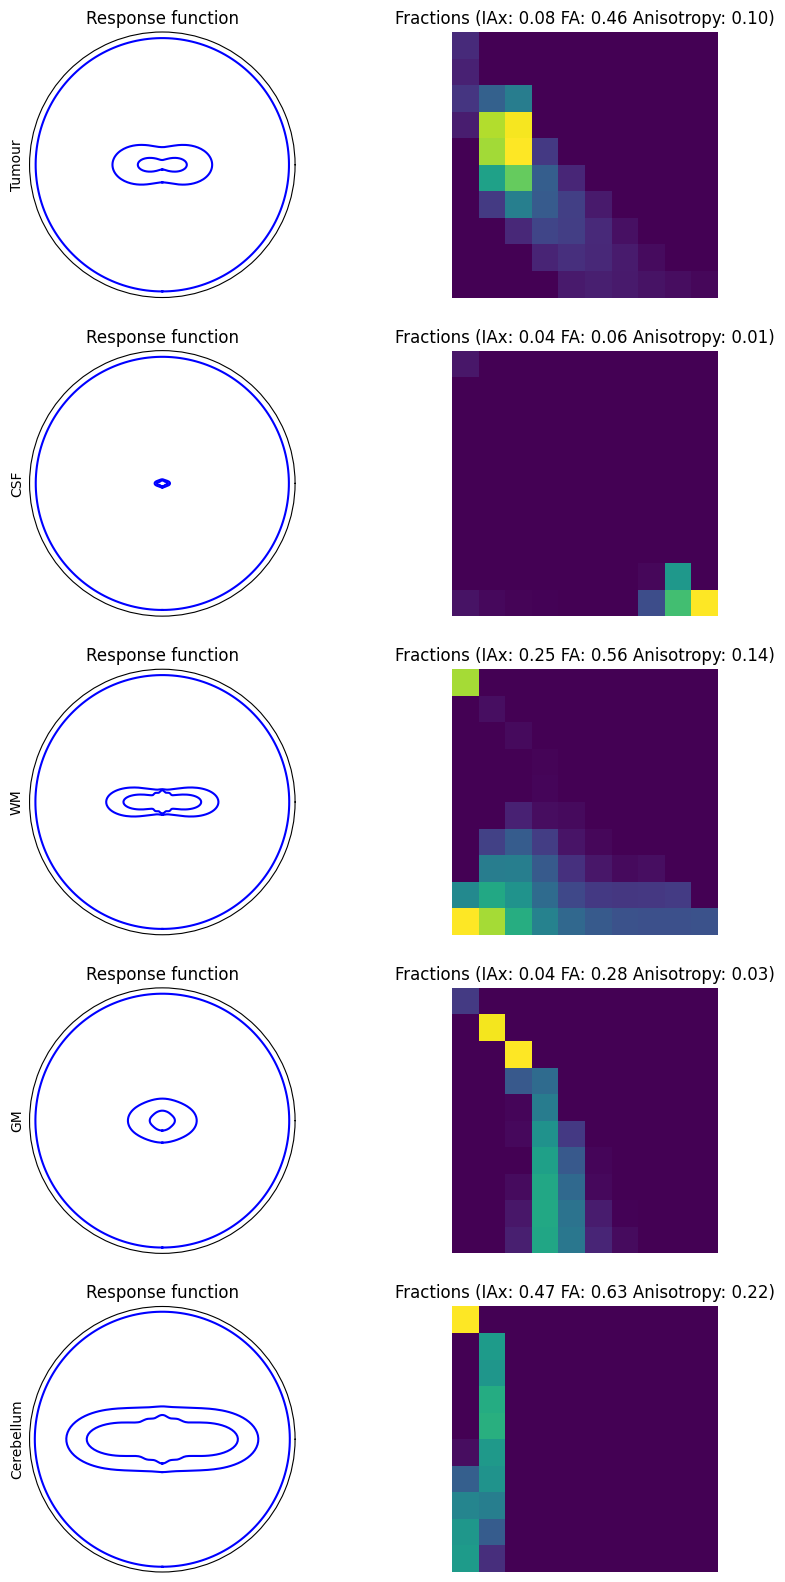

In [144]:
##WM in tumour
rf_tumour = rf[74,67,43]
frac_tumour = fracs[74,67,43]

# CSF
rf_csf = rf[56,64,38]
frac_csf = fracs[56,64,38]

# WM
rf_wm = rf[53,62,42]
frac_wm = fracs[53,62,42]

# GM
rf_gm = rf[50,86,39]
frac_gm = fracs[50,86,39]

# Cerebellum
rf_cerebellum = rf[50,26,9]
frac_cerebellum = fracs[50,26,9]

fig = plt.figure(figsize=(10, 20))
gs = fig.add_gridspec(5,2)

for i, (rf_of_interest, frac_of_interest, title) in enumerate(zip([rf_tumour, rf_csf, rf_wm, rf_gm, rf_cerebellum], [frac_tumour, frac_csf, frac_wm, frac_gm, frac_cerebellum], ['Tumour', 'CSF', 'WM', 'GM', 'Cerebellum'])):
    ax1 = fig.add_subplot(gs[i,0], projection='polar')
    sh.plot_wmr_on_axis(rf_of_interest, bvals, ax1)
    ax1.set_title('Response function')
    ax2 = fig.add_subplot(gs[i,1])

    iax_val = contrasts.get_contrast(frac_of_interest, ad_range, rd_range, contrasts.intra_axonal_contrast, True)
    fa_val = contrasts.get_contrast(frac_of_interest, ad_range, rd_range, fa_map)
    anisotropy = np.linalg.norm(rf_of_interest[1:,1:] / rf_of_interest[0,0])

    ax2.set_title(f'Fractions (IAx: {iax_val:.2f} FA: {fa_val:.2f} Anisotropy: {anisotropy:.2f})')
    ax2.set_axis_off()
    ax1.set_ylabel(title)
    sns.heatmap(frac_of_interest, ax=ax2, cmap='viridis', cbar=False, square=True)

/tmp/ipykernel_779942/380744706.py:4: RuntimeWarning: invalid value encountered in divide
  anisotropy = np.linalg.norm(rf[..., 1:, 1:] / rf[..., :1, :1], axis=(-1,-2))
/tmp/ipykernel_779942/2648233319.py:11: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(np.sqrt(3/2) * np.sqrt((ad_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2) / np.sqrt(ad_matrix**2 + rd_matrix**2 + rd_matrix**2))


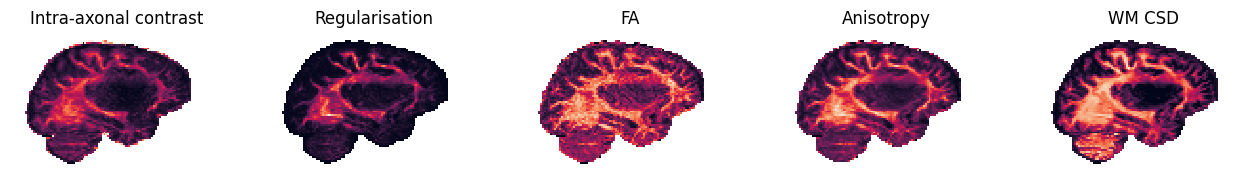

In [153]:
ad_range, rd_range = np.linspace(0, 4e-3, 10), np.linspace(0, 4e-3, 10)

iax = contrasts.get_contrast(fracs, ad_range, rd_range, contrasts.intra_axonal_contrast, True)
anisotropy = np.linalg.norm(rf[..., 1:, 1:] / rf[..., :1, :1], axis=(-1,-2))
fa = contrasts.get_contrast(fracs, ad_range, rd_range, fa_map)
reg = np.sum(rf[...,1:,1:]**2, axis=(-1,-2))

iax /= np.nanmax(iax)
anisotropy /= np.nanmax(anisotropy)
fa /= np.nanmax(fa)
reg /= np.nanmax(reg)

save_mrtrix(f'/LOCALDATA/sleyse4/glioma/sub-{sub}/LORE/reg.mif', Image(reg, vox=data.vox))
save_mrtrix(f'/LOCALDATA/sleyse4/glioma/sub-{sub}/LORE/fa.mif', Image(fa, vox=data.vox))
save_mrtrix(f'/LOCALDATA/sleyse4/glioma/sub-{sub}/LORE/anisotropy.mif', Image(anisotropy, vox=data.vox))

wm_csd = load_mrtrix(f'/LOCALDATA/sleyse4/glioma/sub-{sub}/MTCSD/wm.mif').data[SLICE_IDX,...,0]

fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(1, 5)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[0,4])

sns.heatmap(np.rot90(iax[SLICE_IDX]), ax=ax1, square=True, cbar=False, alpha=np.rot90(mask[SLICE_IDX]))
sns.heatmap(np.rot90(reg[SLICE_IDX]), ax=ax2, square=True, cbar=False, alpha=np.rot90(mask[SLICE_IDX]))
sns.heatmap(np.rot90(fa[SLICE_IDX]), ax=ax3, square=True, cbar=False, alpha=np.rot90(mask[SLICE_IDX]))
sns.heatmap(np.rot90(anisotropy[SLICE_IDX]), ax=ax4, square=True, cbar=False, alpha=np.rot90(mask[SLICE_IDX]))
sns.heatmap(np.rot90(wm_csd), ax=ax5, square=True, cbar=False, alpha=np.rot90(mask[SLICE_IDX]))

ax1.set_title('Intra-axonal contrast')
ax2.set_title('Regularisation')
ax3.set_title('FA')
ax4.set_title('Anisotropy')
ax5.set_title('WM CSD')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')
plt.show()


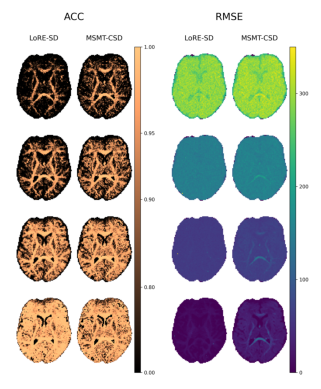

In [274]:
from matplotlib.colors import PowerNorm
import matplotlib.image as mpimg


READ_DIR = f'/LOCALDATA/sleyse4/simulations/'

snr_dict = {
    'snr10': 10,
    'snr20': 20,
    'snr50': 50,
    'noise_free': np.inf
}

x_min, x_max = 25, -25
y_min, y_max = 20, -20
SLICE_IDX = 33

mask = (load_mrtrix(os.path.join(READ_DIR, 'mask.mif')).data > .5)[x_min:x_max,y_min:y_max,SLICE_IDX]

methods = ['LORE', 'MTCSD']
fig = plt.figure(figsize=(8, 12))

# Create separate GridSpec objects for acc and rmse
gs_acc = fig.add_gridspec(len(snr_dict), 3, left=0, right=0.45, width_ratios=[1,1,.1], wspace=-0, hspace=0)
gs_rmse = fig.add_gridspec(len(snr_dict), 3, left=0.55, right=1, width_ratios=[1,1,.1], wspace=-0, hspace=0)

for row, (snr_str, snr) in enumerate(snr_dict.items()):
    ax_acc_LORE = fig.add_subplot(gs_acc[row, 0])
    acc_LORE = load_mrtrix(os.path.join(READ_DIR, snr_str, 'LORE', 'acc.mif')).data[x_min:x_max,y_min:y_max,SLICE_IDX]
    ax_acc_LORE.imshow(np.rot90(acc_LORE), cmap='copper', norm=PowerNorm(vmin=0, vmax=1, gamma=6), alpha=np.rot90(mask).astype(float))
    ax_acc_LORE.axis('off')

    acc_MTCSD = load_mrtrix(os.path.join(READ_DIR, snr_str, 'MTCSD', 'acc.mif')).data[x_min:x_max,y_min:y_max,SLICE_IDX]
    ax_acc_MTCSD = fig.add_subplot(gs_acc[row, 1])
    im_acc = ax_acc_MTCSD.imshow(np.rot90(acc_MTCSD), cmap='copper', norm=PowerNorm(vmin=0, vmax=1, gamma=6), alpha=np.rot90(mask).astype(float))
    ax_acc_MTCSD.axis('off')

    ax_res_LORE = fig.add_subplot(gs_rmse[row, 0])
    res_LORE = load_mrtrix(os.path.join(READ_DIR, snr_str, 'LORE', 'rmse.mif')).data[x_min:x_max,y_min:y_max,SLICE_IDX]
    ax_res_LORE.imshow(np.rot90(res_LORE), cmap='viridis', alpha=np.rot90(mask).astype(float), vmin=0, vmax=350)
    ax_res_LORE.axis('off')

    ax_res_MTCSD = fig.add_subplot(gs_rmse[row, 1])
    res_MTCSD = load_mrtrix(os.path.join(READ_DIR, snr_str, 'MTCSD', 'rmse.mif')).data[x_min:x_max,y_min:y_max,SLICE_IDX]
    im_res = ax_res_MTCSD.imshow(np.rot90(res_MTCSD), cmap='viridis', alpha=np.rot90(mask).astype(float), vmin=0, vmax=350)
    ax_res_MTCSD.axis('off')

ax_cbar_acc = fig.add_subplot(gs_acc[:, -1])
cbar_acc = plt.colorbar(im_acc, cax=ax_cbar_acc)
cbar_acc.ax.set_yticks([0, 0.8, 0.9, 0.95, 1])

ax_cbar_res = fig.add_subplot(gs_rmse[:, -1])
cbar_res = plt.colorbar(im_res, cax=ax_cbar_res)
cbar_res.ax.set_yticks([0, 100, 200, 300])

middle_acc = ax_acc_LORE.get_position().x0 + (ax_acc_MTCSD.get_position().x1 - ax_acc_LORE.get_position().x0) / 2
fig.text(middle_acc, .95, 'ACC', ha='center', va='center', fontsize=20)

middle_res = ax_res_LORE.get_position().x0 + (ax_res_MTCSD.get_position().x1 - ax_res_LORE.get_position().x0) / 2
fig.text(middle_res, .95, 'RMSE', ha='center', va='center', fontsize=20)

middle_acc_LORE = ax_acc_LORE.get_position().x0 + (ax_acc_LORE.get_position().x1 - ax_acc_LORE.get_position().x0) / 2
fig.text(middle_acc_LORE, .9, 'LoRE-SD', ha='center', va='center', fontsize=14)

middle_acc_MTCSD = ax_acc_MTCSD.get_position().x0 + (ax_acc_MTCSD.get_position().x1 - ax_acc_MTCSD.get_position().x0) / 2
fig.text(middle_acc_MTCSD, .9, 'MSMT-CSD', ha='center', va='center', fontsize=14)

middle_res_LORE = ax_res_LORE.get_position().x0 + (ax_res_LORE.get_position().x1 - ax_res_LORE.get_position().x0) / 2
fig.text(middle_res_LORE, .9, 'LoRE-SD', ha='center', va='center', fontsize=14)

middle_res_MTCSD = ax_res_MTCSD.get_position().x0 + (ax_res_MTCSD.get_position().x1 - ax_res_MTCSD.get_position().x0) / 2
fig.text(middle_res_MTCSD, .9, 'MSMT-CSD', ha='center', va='center', fontsize=14)

fig.savefig('/LOCALDATA/sleyse4/rm.png', dpi=300, bbox_inches='tight')
plt.close(fig)
img = mpimg.imread('/LOCALDATA/sleyse4/rm.png')
plt.imshow(img)
plt.axis('off')
plt.show()


In [289]:
from matplotlib.pyplot import setp

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='orange')
    setp(bp['caps'][2], color='orange')
    setp(bp['caps'][3], color='orange')
    setp(bp['whiskers'][2], color='orange')
    setp(bp['whiskers'][3], color='orange')
    setp(bp['medians'][1], color='orange')

    try:
        setp(bp['boxes'][2], color='green')
        setp(bp['caps'][4], color='green')
        setp(bp['caps'][5], color='green')
        setp(bp['whiskers'][4], color='green')
        setp(bp['whiskers'][5], color='green')
        setp(bp['medians'][2], color='green')
    except:
        pass

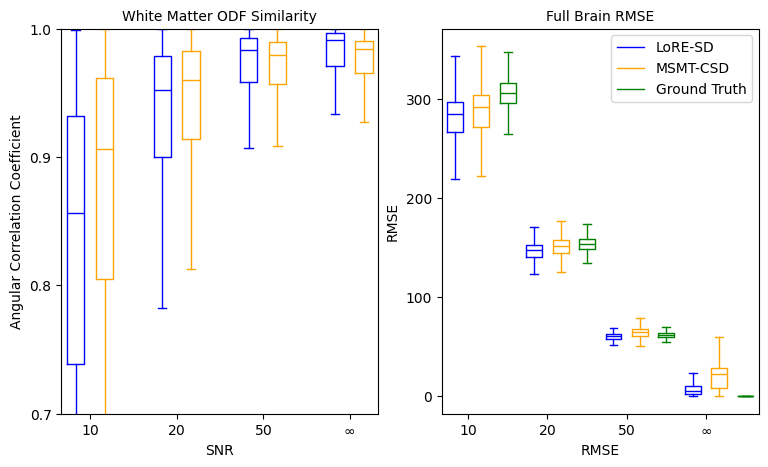

In [338]:
from matplotlib.colors import PowerNorm
import matplotlib.image as mpimg


READ_DIR = f'/LOCALDATA/sleyse4/simulations/'

snr_dict = {
    'snr10': 10,
    'snr20': 20,
    'snr50': 50,
    'noise_free': np.inf
}

x_min, x_max = 25, -25
y_min, y_max = 20, -20
SLICE_IDX = 33

mask = (load_mrtrix(os.path.join(READ_DIR, 'mask.mif')).data > .5)
wm_mask = (load_mrtrix(os.path.join(READ_DIR, '5tt.mif')).data[...,2] > .95)

fig, axs = plt.subplots(1, 2, figsize=(9, 5))

for row, (snr_str, snr) in enumerate(snr_dict.items()):
    acc_LORE = load_mrtrix(os.path.join(READ_DIR, snr_str, 'LORE', 'acc.mif')).data[wm_mask]

    acc_MTCSD = load_mrtrix(os.path.join(READ_DIR, snr_str, 'MTCSD', 'acc.mif')).data[wm_mask]

    res_LORE = load_mrtrix(os.path.join(READ_DIR, snr_str, 'LORE', 'rmse.mif')).data[mask]

    res_MTCSD = load_mrtrix(os.path.join(READ_DIR, snr_str, 'MTCSD', 'rmse.mif')).data[mask]

    gt_rmse = load_mrtrix(os.path.join(READ_DIR, snr_str, 'gt_rmse.mif')).data[mask]

    bp_acc = axs[0].boxplot(
            [acc_LORE, acc_MTCSD],
            positions=[1 + 3 * row, 2 + 3 * row],
            widths=0.6,
            showfliers=False
        )
    setBoxColors(bp_acc)

    bp_res = axs[1].boxplot(
            [res_LORE, res_MTCSD, gt_rmse],
            positions=[1 + 3 * row, 2 + 3 * row, 3+3 * row],
            widths=0.6,
            showfliers=False
        )
    setBoxColors(bp_res)

axs[0].set_xticks([1.5 + 3 * i for i in range(len(snr_dict))])
axs[0].set_xticklabels([rf'${v}$' if v != np.inf else r'$\infty$' for v in snr_dict.values()])
axs[0].set_xlabel('SNR')
axs[0].set_ylim(0.7, 1)
axs[0].set_title('White Matter ODF Similarity', fontsize=10)
if axs[0] != axs.T[0]:
    axs[0].set_yticklabels([])
else:
    axs[0].set_yticks([.7, .8, .9, 1])

axs[0].set_ylabel('Angular Correlation Coefficient')

axs[1].set_xticks([1.5 + 3 * i for i in range(len(snr_dict))])
axs[1].set_xticklabels([rf'${v}$' if v != np.inf else r'$\infty$' for v in snr_dict.values()])
axs[1].set_xlabel('RMSE')
axs[1].set_yticks([0, 100, 200, 300])
axs[1].set_title('Full Brain RMSE', fontsize=10)
if axs[1] != axs.T[1]:
    axs[1].set_yticklabels([])

axs[1].set_ylabel('RMSE')

# Add a legend below the figure
fig.legend([bp_res['boxes'][0], bp_res['boxes'][1], bp_res['boxes'][2]], ['LoRE-SD', 'MSMT-CSD', 'Ground Truth'], 
           ncol=1, fontsize=10, loc='center right', bbox_to_anchor=(.9, .8), frameon=True)


In [394]:
import pandas as pd


GLIOMA_DIR = '/LOCALDATA/sleyse4/glioma/'
DATA_DIR = '/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/'
ORIG_DIR = '/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/DATA/glioma/'

# Find all subdirectories with sub-PTXXX
subjects = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d)) and d.startswith('sub-PT') and '21' not in d]

data = []

for subject in subjects:
    preproc_dir = os.path.join(DATA_DIR, subject)
    lore_dir = os.path.join(GLIOMA_DIR, subject, 'LORE')
    mtcsd_dir = os.path.join(GLIOMA_DIR, subject, 'MTCSD')

    acc = load_mrtrix(os.path.join(GLIOMA_DIR, subject, 'acc.mif')).data
    wm_seg = load_mrtrix(os.path.join(preproc_dir, '5tt_regrid.mif')).data[...,2] > .95

    lesion = load_mrtrix(os.path.join(ORIG_DIR, subject, 'LESION/lesion_regrid.mif')).data > .5
    
    mask = load_mrtrix(os.path.join(GLIOMA_DIR, subject, 'mask.mif')).data > .5
    # Healthy mask is the mask without the lesion
    healthy_mask = np.logical_xor(mask, lesion)

    wm_acc = acc[wm_seg]
    lore_healthy = load_mrtrix(os.path.join(lore_dir, 'rmse.mif')).data[healthy_mask]
    lore_glioma = load_mrtrix(os.path.join(lore_dir, 'rmse.mif')).data[lesion]
    mtcsd_healthy = load_mrtrix(os.path.join(mtcsd_dir, 'rmse.mif')).data[healthy_mask]
    mtcsd_glioma = load_mrtrix(os.path.join(mtcsd_dir, 'rmse.mif')).data[lesion]

    # Remove nan values
    wm_acc = wm_acc[~np.isnan(wm_acc)]
    lore_healthy = lore_healthy[~np.isnan(lore_healthy)]
    lore_glioma = lore_glioma[~np.isnan(lore_glioma)]
    mtcsd_healthy = mtcsd_healthy[~np.isnan(mtcsd_healthy)]
    mtcsd_glioma = mtcsd_glioma[~np.isnan(mtcsd_glioma)]
    
    data += [(subject, wm_acc.mean(), lore_healthy.mean(), lore_glioma.mean(), mtcsd_healthy.mean(), mtcsd_glioma.mean())]
df = pd.DataFrame(data=data, columns=['Subject', 'ACC', 'RMSE LoRE (Healthy)', 'RMSE LoRE (Glioma)', 'RMSE MT-CSD (Healthy)', 'RMSE MT-CSD (Glioma)'])

Text(0.5, 1.0, 'RMSE in Healthy and Glioma Tissues')

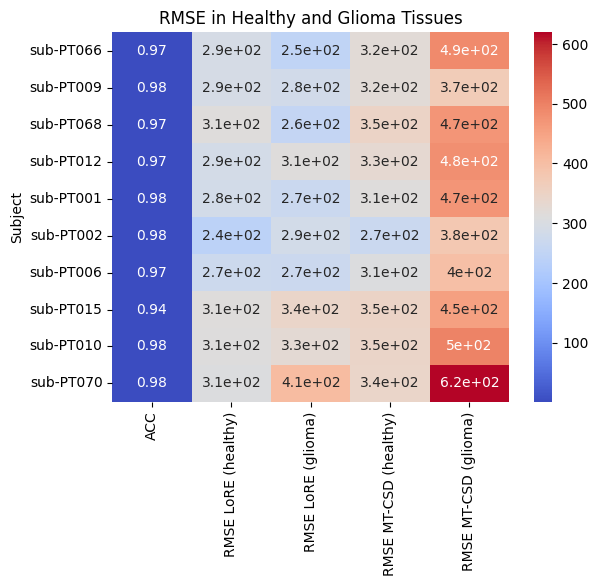

In [395]:
# Heatmap
fig, ax = plt.subplots()
sns.heatmap(df.set_index('Subject'), annot=True, cmap='coolwarm', ax=ax)
ax.set_title('RMSE in Healthy and Glioma Tissues')